<a id='feature-correlation'></a>
<font size="+7" color='#780404'><b> Loan Default Prediction by Manoko Langa</b></font>  

<center><img src ="https://media.istockphoto.com/id/1250089057/vector/banking-crisis-financial-crisis-bank-default.jpg?s=612x612&w=0&k=20&c=9DqM4FcpZnMCktm9mg_nA1GlLuWHzTNpouYZD5EgADg=" width = "750" height = '500'/>

<a id='feature-correlation'></a>
<font size="+5" color='#780404'><b> Importing Libraries</b></font>  

In [356]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
plt.style.use('ggplot') #Applying style to graphs
import termcolor #for customization of text

In [357]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
plt.style.use('ggplot') #Applying style to graphs
import termcolor #for customization of text
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

<center><img src ="https://i.stack.imgur.com/sGHia.png" width = "800" height = '500' alt="unsplash.com"/>

<a id='feature-correlation'></a>
<font size="+6" color='#780404'><b> Loading Data</b></font>  

In [358]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)


In [359]:
demo_train = pd.read_csv("traindemographics.csv")
demo_test = pd.read_csv("testdemographics.csv")  #test data for the demographics
train_perf = pd.read_csv("trainperf.csv")
test_perf = pd.read_csv("testperf.csv")
train_prev = pd.read_csv("trainprevloans.csv")
test_prev = pd.read_csv("testprevloans.csv")
sample_sub = pd.read_csv("SampleSubmission.csv")


In [360]:
demo_train['customerid'].nunique()

4334

In [361]:
demo_train.shape

(4346, 9)

In [362]:
train_perf.shape

(4368, 10)

In [363]:
train_prev.shape

(18183, 12)

In [364]:
sample_sub.head()

,customerid,Good_Bad_flag
0,8a28afc7474813a40147639ec637156b,1
1,8a3735d5518aba7301518ac34413010d,1
2,8a76e7d443e6e97c0143ed099d102b1d,1
3,8a818823525dceef01525deda2480384,1
4,8a818926522ea5ef01523aff15c37482,1


# Dataset and column description

There are 3 different datasets for both train and test.

Note that the sample submission has 2 outcomes- good (1) or bad (0).

1. Demographic data (traindemographics.csv)

- customerid (Primary key used to merge to other data)
- birthdate (date of birth of the customer)
- bank_account_type (type of primary bank account)
- longitude_gps
- latitude_gps
- bank_name_clients (name of the bank)
- bank_branch_clients (location of the branch - not compulsory - so missing in a lot of the cases)
- employment_status_clients (type of employment that customer has)
level_of_education_clients (highest level of education)
2. Performance data (trainperf.csv) : This is the repeat loan that the customer has taken for which we need to predict the performance of. Basically, we need to predict whether this loan would default given all previous loans and demographics of a customer.

- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Loan value taken)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees)
- termdays (Term of loan)
referredby (customerId of the customer that referred this person - is missing, then not referred)
- good_bad_flag (good = settled loan on time; bad = did not settled loan on time) - this is the target variable that we need to predict

3. Previous loans data (trainprevloans.csv) : This dataset contains all previous loans that the customer had prior to the loan above that we want to predict the performance of. Each loan will have a different systemloanid, but the same customerid for each customer.

- customerid (Primary key used to merge to other data)
systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Date that loan application was created)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees) termdays (Term of loan)
- closeddate (Date that the loan was settled)
- referredby (customerId of the customer that referred this person - is missing, then not refrerred)
- firstduedate (Date of first payment due in cases where the term is longer than 30 days. So in the case where the term is 60+ days - then there are multiple monthly payments due - and this dates reflects the date of the first payment)
firstrepaiddate (Actual date that he/she paid the first payment as defined above)


# Data Preprocessing

In [365]:
#lets have a look at the train_prev dataset again

train_prev.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


In [366]:
#lets check the datypes of these columns in this dataset
train_prev.dtypes

customerid          object
systemloanid         int64
loannumber           int64
approveddate        object
creationdate        object
loanamount         float64
totaldue           float64
termdays             int64
closeddate          object
referredby          object
firstduedate        object
firstrepaiddate     object
dtype: object

In [367]:
#lets try and change the datatypes of the columns in this dataset
train_prev['approveddate'] = pd.to_datetime(train_prev['approveddate'])
train_prev['creationdate'] = pd.to_datetime(train_prev['creationdate'])
train_prev['closeddate'] = pd.to_datetime(train_prev['closeddate'])
train_prev['firstduedate'] = pd.to_datetime(train_prev['firstduedate'])
train_prev['firstrepaiddate'] = pd.to_datetime(train_prev['firstrepaiddate'])
train_prev['customerid'] = train_prev['customerid'].astype(str)  # Convert customerid to string

#checking the updated dtypes
train_prev.dtypes

customerid                 object
systemloanid                int64
loannumber                  int64
approveddate       datetime64[ns]
creationdate       datetime64[ns]
loanamount                float64
totaldue                  float64
termdays                    int64
closeddate         datetime64[ns]
referredby                 object
firstduedate       datetime64[ns]
firstrepaiddate    datetime64[ns]
dtype: object

- In this code, I used the pd.to_datetime() function to convert the date columns ('approveddate', 'creationdate', 'closeddate', 'firstduedate', 'firstrepaiddate') to the appropriate datetime data type.

- I also converted `'customerid'` to string using astype(str) since it is not advisable to handle 'customerid' as an integer due to the possibility of leading zeros being truncated, especially if the 'customerid' contains values that are better represented as strings (e.g., alphanumeric values).


In [368]:
#checking the datatypes of the perfomance dataset
train_perf.dtypes

customerid        object
systemloanid       int64
loannumber         int64
approveddate      object
creationdate      object
loanamount       float64
totaldue         float64
termdays           int64
referredby        object
good_bad_flag     object
dtype: object

In [369]:

# Converting columns to their appropriate data types
train_perf['approveddate'] = pd.to_datetime(train_perf['approveddate'])
train_perf['creationdate'] = pd.to_datetime(train_perf['creationdate'])
train_perf['referredby'] = train_perf['referredby'].astype(str)  # Convert referredby to string
train_perf['good_bad_flag'] = train_perf['good_bad_flag'].astype(str)  # Convert good_bad_flag to string

train_perf.dtypes


customerid               object
systemloanid              int64
loannumber                int64
approveddate     datetime64[ns]
creationdate     datetime64[ns]
loanamount              float64
totaldue                float64
termdays                  int64
referredby               object
good_bad_flag            object
dtype: object

## checking nulls in our dataset

In [370]:
# Check for null values in each dataset
train_prev_null = train_prev.isnull().values.any()
train_perf_null = train_perf.isnull().values.any()
demo_train_null = demo_train.isnull().values.any()

# Print the results
print("Null values in train_prev:", train_prev_null)
print("Null values in train_perf:", train_perf_null)
print("Null values in demo_train:", demo_train_null)

Null values in train_prev: True
Null values in train_perf: False
Null values in demo_train: True


- There is only one dataset in our analysis that has no null values and that is the train performance.

## Dropping some of the columns in our dataset

In [371]:
#some columns are not going to be effective in predicting if whether will default or not, so lets drop them.

train_prev.head(2)

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40,2016-08-15 17:22:32,10000.0,13000.0,30,2016-09-01 16:06:48,NaN,2016-09-14,2016-09-01 15:51:43
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07,2017-04-28 17:38:53,10000.0,13000.0,30,2017-05-28 14:44:49,NaN,2017-05-30,2017-05-26 00:00:00


In [372]:
# Drop the columns "creationdate" and "referredby" from 'train_prev' in-place
train_prev.drop(["creationdate", "referredby", "systemloanid"], axis=1, inplace=True)

In [373]:
train_prev.head()

,customerid,loannumber,approveddate,loanamount,totaldue,termdays,closeddate,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,2,2016-08-15 18:22:40,10000.0,13000.0,30,2016-09-01 16:06:48,2016-09-14,2016-09-01 15:51:43
1,8a2a81a74ce8c05d014cfb32a0da1049,9,2017-04-28 18:39:07,10000.0,13000.0,30,2017-05-28 14:44:49,2017-05-30,2017-05-26 00:00:00
2,8a2a81a74ce8c05d014cfb32a0da1049,8,2017-03-05 10:56:25,20000.0,23800.0,30,2017-04-26 22:18:56,2017-04-04,2017-04-26 22:03:47
3,8a8588f35438fe12015444567666018e,5,2017-04-09 18:25:55,10000.0,11500.0,15,2017-04-24 01:35:52,2017-04-24,2017-04-24 00:48:43
4,8a85890754145ace015429211b513e16,2,2017-06-17 09:29:57,10000.0,11500.0,15,2017-07-14 21:18:43,2017-07-03,2017-07-14 21:08:35


## Feature Engineering

In [374]:
import pandas as pd

# Assuming you have a DataFrame named 'train_prev'
# and the columns ['firstduedate', 'firstrepaiddate', 'termdays'] are present.

# Convert the date columns to datetime format for proper date operations
train_prev['firstduedate'] = pd.to_datetime(train_prev['firstduedate'])
train_prev['firstrepaiddate'] = pd.to_datetime(train_prev['firstrepaiddate'])

# Function to calculate the days in advance (or delay) of repayment
def calculate_days_in_advance(row):
    due_date = row['firstduedate']
    repaid_date = row['firstrepaiddate']

    days_difference = (repaid_date - due_date).days

    # Check if the payment was made after the due date
    if days_difference > 0:
        # Report the number of days after the due date as a negative value
        days_in_advance = -days_difference
    else:
        # Report the number of days in advance if paid before the due date or on the exact day
        days_in_advance = -days_difference

    return days_in_advance

# Apply the custom function to create the new column 'days_in_advance'
train_prev['days_in_advance'] = train_prev.apply(calculate_days_in_advance, axis=1)

# Display the modified DataFrame with the new 'days_in_advance' column
train_prev


,customerid,loannumber,approveddate,loanamount,totaldue,termdays,closeddate,firstduedate,firstrepaiddate,days_in_advance
0,8a2a81a74ce8c05d014cfb32a0da1049,2,2016-08-15 18:22:40,10000.0,13000.0,30,2016-09-01 16:06:48,2016-09-14,2016-09-01 15:51:43,13
1,8a2a81a74ce8c05d014cfb32a0da1049,9,2017-04-28 18:39:07,10000.0,13000.0,30,2017-05-28 14:44:49,2017-05-30,2017-05-26 00:00:00,4
2,8a2a81a74ce8c05d014cfb32a0da1049,8,2017-03-05 10:56:25,20000.0,23800.0,30,2017-04-26 22:18:56,2017-04-04,2017-04-26 22:03:47,-22
3,8a8588f35438fe12015444567666018e,5,2017-04-09 18:25:55,10000.0,11500.0,15,2017-04-24 01:35:52,2017-04-24,2017-04-24 00:48:43,0
4,8a85890754145ace015429211b513e16,2,2017-06-17 09:29:57,10000.0,11500.0,15,2017-07-14 21:18:43,2017-07-03,2017-07-14 21:08:35,-11
...,...,...,...,...,...,...,...,...,...,...
18178,8a858899538ddb8e0153a2b555421fc5,2,2016-04-16 13:36:34,10000.0,13000.0,30,2016-05-14 00:04:52,2016-05-16,2016-05-13 18:05:07,3
18179,8a858899538ddb8e0153a2b555421fc5,9,2016-11-18 14:26:07,30000.0,34400.0,30,2016-12-13 16:08:57,2016-12-19,2016-12-13 15:53:48,6
18180,8a858899538ddb8e0153a2b555421fc5,4,2016-06-12 15:30:56,10000.0,13000.0,30,2016-07-09 15:39:00,2016-07-12,2016-07-09 15:23:56,3
18181,8a858f0656b7820c0156c92ca3ba436f,1,2016-08-27 20:03:45,10000.0,13000.0,30,2016-10-15 10:17:54,2016-09-26,2016-10-15 10:02:45,-19


In [375]:
#lets also extract which exact day of the month the clients had to pay
# Convert the date columns to datetime format for proper date operations
train_prev['firstduedate'] = pd.to_datetime(train_prev['firstduedate'])
train_prev['approveddate'] = pd.to_datetime(train_prev['approveddate'])

# Extract the day of the month from 'firstduedate' and store it in a new column 'due_day'
train_prev['due_day'] = train_prev['firstduedate'].dt.day


In [376]:
train_prev.head()

,customerid,loannumber,approveddate,loanamount,totaldue,termdays,closeddate,firstduedate,firstrepaiddate,days_in_advance,due_day
0,8a2a81a74ce8c05d014cfb32a0da1049,2,2016-08-15 18:22:40,10000.0,13000.0,30,2016-09-01 16:06:48,2016-09-14,2016-09-01 15:51:43,13,14
1,8a2a81a74ce8c05d014cfb32a0da1049,9,2017-04-28 18:39:07,10000.0,13000.0,30,2017-05-28 14:44:49,2017-05-30,2017-05-26 00:00:00,4,30
2,8a2a81a74ce8c05d014cfb32a0da1049,8,2017-03-05 10:56:25,20000.0,23800.0,30,2017-04-26 22:18:56,2017-04-04,2017-04-26 22:03:47,-22,4
3,8a8588f35438fe12015444567666018e,5,2017-04-09 18:25:55,10000.0,11500.0,15,2017-04-24 01:35:52,2017-04-24,2017-04-24 00:48:43,0,24
4,8a85890754145ace015429211b513e16,2,2017-06-17 09:29:57,10000.0,11500.0,15,2017-07-14 21:18:43,2017-07-03,2017-07-14 21:08:35,-11,3


In [377]:
vv = train_prev.groupby('customerid').count().reset_index()
# vv1 = train_prev.groupby('loannumber').max().reset_index()
# vv3 = vv['loannumber']
vv1 = train_prev.groupby('customerid').mean().reset_index()
vv1['loannumber'] = vv['loannumber']
vv1

/var/folders/mc/wtr2th093fscq0l5wyyg1yg00000gq/T/ipykernel_39685/2557475613.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  vv1 = train_prev.groupby('customerid').mean().reset_index()


,customerid,loannumber,loanamount,totaldue,termdays,days_in_advance,due_day
0,8a1088a0484472eb01484669e3ce4e0b,1,10000.000000,11500.000000,15.000000,-6.000000,18.000000
1,8a1a1e7e4f707f8b014f797718316cad,4,17500.000000,22375.000000,37.500000,0.250000,17.750000
2,8a1a32fc49b632520149c3b8fdf85139,7,12857.142857,15214.285714,19.285714,0.428571,14.285714
3,8a1eb5ba49a682300149c3c068b806c7,8,16250.000000,20300.000000,33.750000,3.125000,12.125000
4,8a1edbf14734127f0147356fdb1b1eb2,2,10000.000000,12250.000000,22.500000,4.000000,3.000000
...,...,...,...,...,...,...,...
4354,8a858fff5a28d297015a33bc2e845305,6,16666.666667,20933.333333,35.000000,13.000000,9.666667
4355,8a858fff5a36fe68015a37f8550a02a2,6,15000.000000,18383.333333,27.500000,3.000000,18.333333
4356,8a858fff5a36fe68015a3ac5851618ab,1,10000.000000,13000.000000,30.000000,2.000000,6.000000
4357,8a858fff5a36fe68015a3b8dcb8a3843,6,13333.333333,16075.000000,22.500000,2.833333,11.500000


In [378]:
train_prev[train_prev['customerid']=='8a1088a0484472eb01484669e3ce4e0b']

,customerid,loannumber,approveddate,loanamount,totaldue,termdays,closeddate,firstduedate,firstrepaiddate,days_in_advance,due_day
1893,8a1088a0484472eb01484669e3ce4e0b,1,2017-07-02 19:19:01,10000.0,11500.0,15,2017-07-24 20:50:43,2017-07-18,2017-07-24 20:40:34,-6,18


- we can now delete more features which we no longer need from the previous dataset

## Merging the datasets

In [379]:
vv1.shape

(4359, 7)

In [380]:
train_perf.shape

(4368, 10)

In [381]:
# Merge the Performance and Previous Loans Data
merged_train_loans = pd.merge(vv1, train_perf, on='customerid')

# Verify the merged DataFrame
merged_train_loans['customerid'].nunique()

4359

In [382]:
merged_train_loans.head()

,customerid,loannumber_x,loanamount_x,totaldue_x,termdays_x,days_in_advance,due_day,systemloanid,loannumber_y,approveddate,creationdate,loanamount_y,totaldue_y,termdays_y,referredby,good_bad_flag
0,8a1088a0484472eb01484669e3ce4e0b,1,10000.000000,11500.000000,15.000000,-6.000000,18.000000,301999397,2,2017-07-27 19:44:08,2017-07-27 18:44:00,10000.0,11500.0,15,nan,Bad
1,8a1a1e7e4f707f8b014f797718316cad,4,17500.000000,22375.000000,37.500000,0.250000,17.750000,301997672,5,2017-07-26 20:01:54,2017-07-26 19:01:46,30000.0,39000.0,60,nan,Good
2,8a1a32fc49b632520149c3b8fdf85139,7,12857.142857,15214.285714,19.285714,0.428571,14.285714,301976551,8,2017-07-13 19:22:15,2017-07-13 18:22:05,20000.0,24500.0,30,nan,Good
3,8a1eb5ba49a682300149c3c068b806c7,8,16250.000000,20300.000000,33.750000,3.125000,12.125000,301975382,9,2017-07-13 00:34:03,2017-07-12 23:33:54,30000.0,39000.0,60,nan,Good
4,8a1edbf14734127f0147356fdb1b1eb2,2,10000.000000,12250.000000,22.500000,4.000000,3.000000,301979352,3,2017-07-15 16:02:04,2017-07-15 15:01:56,10000.0,11500.0,15,nan,Good


In [383]:
merged_train_loans.shape

(4359, 16)

In [384]:
# Merge the Demographics Data with the Merged Loans Data
df_train = pd.merge(demo_train, merged_train_loans, on='customerid')

# Verify the final merged DataFrame
df_train


,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,loannumber_x,loanamount_x,totaldue_x,termdays_x,days_in_advance,due_day,systemloanid,loannumber_y,approveddate,creationdate,loanamount_y,totaldue_y,termdays_y,referredby,good_bad_flag
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN,1,10000.000000,11500.000000,15.0,1.000000,5.000000,301964962,2,2017-07-05 14:29:48,2017-07-05 13:29:42,10000.0,13000.0,30,8a858899538ddb8e0153a780c56e34bb,Good
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN,1,10000.000000,13000.000000,30.0,-3.000000,7.000000,301972172,2,2017-07-10 21:21:46,2017-07-10 20:21:40,10000.0,13000.0,30,nan,Bad
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN,3,10000.000000,12000.000000,20.0,-0.333333,15.000000,301976271,4,2017-07-13 15:40:27,2017-07-13 14:40:19,10000.0,13000.0,30,nan,Good
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN,1,10000.000000,11500.000000,15.0,-18.000000,30.000000,301997763,2,2017-07-26 21:03:17,2017-07-26 20:03:09,10000.0,11500.0,15,nan,Good
4,8a858ea05a859123015a8892914d15b7,1990-07-21 00:00:00.000000,Savings,3.365935,6.564823,Access Bank,NaN,Permanent,NaN,5,14000.000000,17600.000000,30.0,3.200000,26.000000,301992494,6,2017-07-23 21:44:43,2017-07-23 20:44:36,20000.0,24500.0,30,nan,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267,8a858f735b437619015b437bf3d30bdc,1982-10-19 00:00:00.000000,Savings,3.306874,6.669184,GT Bank,NaN,Permanent,NaN,2,10000.000000,11500.000000,15.0,2.000000,26.000000,301978422,3,2017-07-14 22:08:22,2017-07-14 21:07:13,10000.0,11500.0,15,nan,Bad
3268,8a858fc45c5f93be015c61e0e5e55e38,1986-02-16 00:00:00.000000,Savings,3.353483,6.651007,GT Bank,NaN,NaN,NaN,2,10000.000000,11500.000000,15.0,3.500000,8.000000,301981333,3,2017-07-17 08:52:06,2017-07-17 07:52:00,10000.0,11500.0,15,nan,Good
3269,8a85897353d85af80153d8a368020159,1983-06-07 00:00:00.000000,Other,7.046360,5.499944,UBA,NaN,Self-Employed,NaN,10,15500.000000,17997.500000,22.5,2.400000,11.100000,301971930,11,2017-07-10 18:04:26,2017-07-10 17:04:21,40000.0,44000.0,30,nan,Good
3270,8a858f155554552501555588ca2b3b40,1985-12-13 00:00:00.000000,Other,3.236753,7.030168,Stanbic IBTC,NaN,Permanent,Graduate,6,11666.666667,14583.333333,27.5,0.833333,18.166667,301990956,7,2017-07-22 16:07:16,2017-07-22 15:07:02,20000.0,24500.0,30,nan,Good


In [385]:
df_train.shape

(3272, 24)

- This is our final train dataset that we will have to work with and we can now try and do some data pre-processing on it

<a id='feature-correlation'></a>
<font size="+5" color='#780404'><b> Data Preprocessing</b></font>  

In [386]:
#Checking that all columns in the data are of appropriate type for analysis
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3272 entries, 0 to 3271
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   customerid                  3272 non-null   object        
 1   birthdate                   3272 non-null   object        
 2   bank_account_type           3272 non-null   object        
 3   longitude_gps               3272 non-null   float64       
 4   latitude_gps                3272 non-null   float64       
 5   bank_name_clients           3272 non-null   object        
 6   bank_branch_clients         30 non-null     object        
 7   employment_status_clients   2779 non-null   object        
 8   level_of_education_clients  440 non-null    object        
 9   loannumber_x                3272 non-null   int64         
 10  loanamount_x                3272 non-null   float64       
 11  totaldue_x                  3272 non-null   float64     

-clearly, not all columns are in their appropriate data type.

In [387]:
#Checking for any missing values in the DataFrame
df_train.isnull().values.any()

True

- There are missing values in the dataset. Let us now check what these missing values are.

In [388]:
df_train.isnull().sum()

customerid                       0
birthdate                        0
bank_account_type                0
longitude_gps                    0
latitude_gps                     0
bank_name_clients                0
bank_branch_clients           3242
employment_status_clients      493
level_of_education_clients    2832
loannumber_x                     0
loanamount_x                     0
totaldue_x                       0
termdays_x                       0
days_in_advance                  0
due_day                          0
systemloanid                     0
loannumber_y                     0
approveddate                     0
creationdate                     0
loanamount_y                     0
totaldue_y                       0
termdays_y                       0
referredby                       0
good_bad_flag                    0
dtype: int64

In [389]:
#Checking for duplicates
df_train.duplicated().any()

True

In [390]:
df_train.duplicated().sum()

8

In [391]:


# Assuming you have already loaded and merged your data into a DataFrame called 'merged_train_data'

# Check for duplicated rows in the DataFrame
duplicated_rows = df_train.duplicated()

# Filter the DataFrame to show only the duplicated rows
duplicated_data = df_train[duplicated_rows]

# Display the duplicated data
print("Duplicated Rows:")
print(duplicated_data)

# Optionally, you can also count the number of duplicated rows
num_duplicated_rows = duplicated_rows.sum()
print("Number of Duplicated Rows:", num_duplicated_rows)


Duplicated Rows:
                            customerid                   birthdate  \
338   8a858e6c5c88d145015c8b9627cd5a48  1979-09-30 00:00:00.000000   
611   8a858fc75cd62882015cdaf2f4311b3f  1975-10-27 00:00:00.000000   
775   8a858fe65675195a015679452588279c  1982-08-01 00:00:00.000000   
1019  8a858fe05d421ff4015d4c87d2a21ceb  1983-01-20 00:00:00.000000   
1158  8a858ec65cc6352b015cc64525ea0763  1985-01-30 00:00:00.000000   
2266  8a858f1e5baffcc9015bb02b505f180d  1983-04-06 00:00:00.000000   
2662  8a858f9f5679951a01567a5b90644817  1984-12-17 00:00:00.000000   
3108  8a858f1e5cc4bc81015cc548e1eb5206  1979-09-15 00:00:00.000000   

     bank_account_type  longitude_gps  latitude_gps bank_name_clients  \
338            Savings       3.367008      6.497313     Sterling Bank   
611            Savings       7.437607      9.088935           GT Bank   
775            Savings       7.533646      9.046885               UBA   
1019           Savings       8.526960     12.023015         

In [392]:
# Drop duplicates from the DataFrame
df_train.drop_duplicates(inplace=True)

In [393]:
#Checking for duplicates
df_train.duplicated().any()

False

In [394]:
df_train.shape

(3264, 24)

In [395]:
df_train.dtypes

customerid                            object
birthdate                             object
bank_account_type                     object
longitude_gps                        float64
latitude_gps                         float64
bank_name_clients                     object
bank_branch_clients                   object
employment_status_clients             object
level_of_education_clients            object
loannumber_x                           int64
loanamount_x                         float64
totaldue_x                           float64
termdays_x                           float64
days_in_advance                      float64
due_day                              float64
systemloanid                           int64
loannumber_y                           int64
approveddate                  datetime64[ns]
creationdate                  datetime64[ns]
loanamount_y                         float64
totaldue_y                           float64
termdays_y                             int64
referredby

<a id='feature-correlation'></a>
<font size="+5" color='#780404'><b> Data Cleaning</b></font>  

In [396]:
df_train.head(2)

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,loannumber_x,loanamount_x,totaldue_x,termdays_x,days_in_advance,due_day,systemloanid,loannumber_y,approveddate,creationdate,loanamount_y,totaldue_y,termdays_y,referredby,good_bad_flag
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN,1,10000.0,11500.0,15.0,1.0,5.0,301964962,2,2017-07-05 14:29:48,2017-07-05 13:29:42,10000.0,13000.0,30,8a858899538ddb8e0153a780c56e34bb,Good
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN,1,10000.0,13000.0,30.0,-3.0,7.0,301972172,2,2017-07-10 21:21:46,2017-07-10 20:21:40,10000.0,13000.0,30,nan,Bad


In [397]:
#dropping unnecessary columns
df_train.drop(["bank_branch_clients"], axis=1, inplace=True)
df_train

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients,loannumber_x,loanamount_x,totaldue_x,termdays_x,days_in_advance,due_day,systemloanid,loannumber_y,approveddate,creationdate,loanamount_y,totaldue_y,termdays_y,referredby,good_bad_flag
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,1,10000.000000,11500.000000,15.0,1.000000,5.000000,301964962,2,2017-07-05 14:29:48,2017-07-05 13:29:42,10000.0,13000.0,30,8a858899538ddb8e0153a780c56e34bb,Good
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,Permanent,NaN,1,10000.000000,13000.000000,30.0,-3.000000,7.000000,301972172,2,2017-07-10 21:21:46,2017-07-10 20:21:40,10000.0,13000.0,30,nan,Bad
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,3,10000.000000,12000.000000,20.0,-0.333333,15.000000,301976271,4,2017-07-13 15:40:27,2017-07-13 14:40:19,10000.0,13000.0,30,nan,Good
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,Permanent,NaN,1,10000.000000,11500.000000,15.0,-18.000000,30.000000,301997763,2,2017-07-26 21:03:17,2017-07-26 20:03:09,10000.0,11500.0,15,nan,Good
4,8a858ea05a859123015a8892914d15b7,1990-07-21 00:00:00.000000,Savings,3.365935,6.564823,Access Bank,Permanent,NaN,5,14000.000000,17600.000000,30.0,3.200000,26.000000,301992494,6,2017-07-23 21:44:43,2017-07-23 20:44:36,20000.0,24500.0,30,nan,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267,8a858f735b437619015b437bf3d30bdc,1982-10-19 00:00:00.000000,Savings,3.306874,6.669184,GT Bank,Permanent,NaN,2,10000.000000,11500.000000,15.0,2.000000,26.000000,301978422,3,2017-07-14 22:08:22,2017-07-14 21:07:13,10000.0,11500.0,15,nan,Bad
3268,8a858fc45c5f93be015c61e0e5e55e38,1986-02-16 00:00:00.000000,Savings,3.353483,6.651007,GT Bank,NaN,NaN,2,10000.000000,11500.000000,15.0,3.500000,8.000000,301981333,3,2017-07-17 08:52:06,2017-07-17 07:52:00,10000.0,11500.0,15,nan,Good
3269,8a85897353d85af80153d8a368020159,1983-06-07 00:00:00.000000,Other,7.046360,5.499944,UBA,Self-Employed,NaN,10,15500.000000,17997.500000,22.5,2.400000,11.100000,301971930,11,2017-07-10 18:04:26,2017-07-10 17:04:21,40000.0,44000.0,30,nan,Good
3270,8a858f155554552501555588ca2b3b40,1985-12-13 00:00:00.000000,Other,3.236753,7.030168,Stanbic IBTC,Permanent,Graduate,6,11666.666667,14583.333333,27.5,0.833333,18.166667,301990956,7,2017-07-22 16:07:16,2017-07-22 15:07:02,20000.0,24500.0,30,nan,Good


In [398]:
df_train.loanamount_x.describe()

count     3264.000000
mean     12946.446574
std       4853.360035
min       5000.000000
25%      10000.000000
50%      10000.000000
75%      14444.444444
max      36666.666667
Name: loanamount_x, dtype: float64

In [399]:

# Dropping more columns from the performance dataset
df_train.drop(["loannumber_y", "creationdate", "loanamount_y", "totaldue_y", "termdays_y", "referredby", "systemloanid"], axis=1, inplace=True)


In [400]:
#renaming the columns in my dataset
# Define a dictionary to map the old column names to the new column names
column_rename_mapping = {
    'loannumber_x': 'loannumber',
    'loanamount_x': 'loanamount',
    'totaldue_x': 'totaldue',
    'termdays_x': 'termdays'
}

# Rename the columns in the DataFrame
df_train.rename(columns=column_rename_mapping, inplace=True)

In [401]:
df_train.head(2)

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients,loannumber,loanamount,totaldue,termdays,days_in_advance,due_day,approveddate,good_bad_flag
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,1,10000.0,11500.0,15.0,1.0,5.0,2017-07-05 14:29:48,Good
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,Permanent,NaN,1,10000.0,13000.0,30.0,-3.0,7.0,2017-07-10 21:21:46,Bad


In [402]:
df_train.shape

(3264, 16)

In [403]:
# Calculating the percentage of null values in each column
null_percentage = (df_train.isnull().sum() / len(df_train)) * 100

# Optionally, you can display the percentage of null values for each column
print("Percentage of null values in each column:")
print(null_percentage)

Percentage of null values in each column:
customerid                     0.000000
birthdate                      0.000000
bank_account_type              0.000000
longitude_gps                  0.000000
latitude_gps                   0.000000
bank_name_clients              0.000000
employment_status_clients     15.104167
level_of_education_clients    86.519608
loannumber                     0.000000
loanamount                     0.000000
totaldue                       0.000000
termdays                       0.000000
days_in_advance                0.000000
due_day                        0.000000
approveddate                   0.000000
good_bad_flag                  0.000000
dtype: float64


In [404]:
employment_status_mode = df_train['employment_status_clients'].mode()[0]

# Fill null values in the 'employment_status_clients' column with the mode
df_train['employment_status_clients'].fillna(employment_status_mode, inplace=True)

In [405]:
# Fill null values in the 'level_of_education_clients' column with "missing"
df_train['level_of_education_clients'].fillna("missing", inplace=True)
df_train['level_of_education_clients'].fillna("mean", inplace=True)

In [406]:
# Calculating the percentage of null values in each column
null_percentage = (df_train.isnull().sum() / len(df_train)) * 100

# Optionally, you can display the percentage of null values for each column
print("Percentage of null values in each column:")
print(null_percentage)

Percentage of null values in each column:
customerid                    0.0
birthdate                     0.0
bank_account_type             0.0
longitude_gps                 0.0
latitude_gps                  0.0
bank_name_clients             0.0
employment_status_clients     0.0
level_of_education_clients    0.0
loannumber                    0.0
loanamount                    0.0
totaldue                      0.0
termdays                      0.0
days_in_advance               0.0
due_day                       0.0
approveddate                  0.0
good_bad_flag                 0.0
dtype: float64


Looks like we no longer have any null values now.

<a id='feature-correlation'></a>
<font size="+5" color='#780404'><b> Exploratory Data Analysis</b></font>  

<center><img src ="https://www.researchgate.net/profile/Chris-Evelo/publication/46170882/figure/fig2/AS:341568864178180@1458447771245/Pathways-for-exploratory-data-analysis-Biological-pathways-are-powerful-visualization_Q320.jpg" width = "800" height = '500'/>

## Part 1: Non-Graphical Exploratory Analysis

In [407]:
df_train.describe()

,longitude_gps,latitude_gps,loannumber,loanamount,totaldue,termdays,days_in_advance,due_day
count,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000
mean,4.532037,7.290795,4.189032,12946.446574,15682.448004,25.361901,2.334661,15.709187
std,7.931426,3.272046,3.667968,4853.360035,5421.861351,6.868827,7.392888,6.655245
min,-118.247009,-33.868818,1.000000,5000.000000,5750.000000,15.000000,-121.000000,1.000000
25%,3.354830,6.473632,1.000000,10000.000000,12250.000000,20.000000,0.000000,11.000000
50%,3.585039,6.625506,3.000000,10000.000000,13000.000000,27.857143,2.333333,15.781746
75%,6.458061,7.426989,6.000000,14444.444444,17506.770833,30.000000,5.333333,20.000000
max,151.209290,71.228069,26.000000,36666.666667,41252.380952,60.000000,30.000000,31.000000


In [408]:
df_train.good_bad_flag.mode()

0    Good
Name: good_bad_flag, dtype: object

In [409]:
#checking the skewness of the dataset
df_train.skew()

/var/folders/mc/wtr2th093fscq0l5wyyg1yg00000gq/T/ipykernel_39685/2773242123.py:2: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_train.skew()


longitude_gps     -3.205028
latitude_gps       9.351353
loannumber         1.317616
loanamount         1.745952
totaldue           1.708770
termdays           0.018740
days_in_advance   -3.124901
due_day            0.106458
dtype: float64

Interpretation:

- `termdays` and `due_day`, `  are the only columns that are fairly symmetrical (i.e They have a skew value within this range -0.5 < x < 0.5)

- The rest of the other columns are highly skewed in a positive direction, but `latitude_gps` is the column with the highest skeweness in the postive direction with a value of ~9.





In [410]:
#checking for outliers in our dataset
df_train.kurtosis()

/var/folders/mc/wtr2th093fscq0l5wyyg1yg00000gq/T/ipykernel_39685/64361926.py:2: FutureWarning: The default value of numeric_only in DataFrame.kurt is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_train.kurtosis()


longitude_gps      166.182637
latitude_gps       143.524946
loannumber           1.520391
loanamount           2.359769
totaldue             2.310825
termdays             0.112924
days_in_advance     45.514652
due_day             -0.383694
dtype: float64

- `loannumber`, `loanamount`, `totaldue`, `termdays`, `due_day` are the only columns with a low kurtosis indicating that they do not have outliers.

- The rest of the other columns appear to have outliers, with  `longitude_gps` and `latitude_gps` having most of the outliers.

<a id='feature-correlation'></a>
<font size="+5" color='#780404'><b> Feature Engineering</b></font>  

In [411]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [412]:
# from geopy.geocoders import Nominatim
# import pandas as pd

# # Function to get location name from latitude and longitude using Nominatim
# def get_location_name(latitudes, longitudes, geolocator):
#     locations = []
#     for lat, lon in zip(latitudes, longitudes):
#         location = geolocator.reverse((lat, lon), exactly_one=True)
#         locations.append(location.address if location else None)
#     return locations

# # Initialize the geolocator
# geolocator = Nominatim(user_agent="geoapiExercises")

# # Assuming you have already loaded your dataset into a DataFrame named 'df_train'
# # Split the dataset into smaller batches (batch size = 100 in this example)
# batch_size = 100
# num_batches = (len(df_train) // batch_size) + 1

# # Create an empty list to store location names
# location_names = []

# # Process each batch separately
# for batch in range(num_batches):
#     start_idx = batch * batch_size
#     end_idx = (batch + 1) * batch_size

#     # Get latitude and longitude values for the current batch
#     latitudes = df_train['latitude_gps'].iloc[start_idx:end_idx]
#     longitudes = df_train['longitude_gps'].iloc[start_idx:end_idx]

#     # Batch reverse geocoding for the current batch
#     batch_locations = get_location_name(latitudes, longitudes, geolocator)
#     location_names.extend(batch_locations)

# # Assign the location names to the DataFrame
# df_train['location_name'] = location_names

# # Save the DataFrame to a new CSV file or perform further analysis
# df_train.to_csv('processed_data.csv', index=False)


In [413]:
 #Save the DataFrame to a new CSV file or perform further analysis
df_train.to_csv('processed_data.csv', index=False)

In [414]:
df_train.head(2)

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients,loannumber,loanamount,totaldue,termdays,days_in_advance,due_day,approveddate,good_bad_flag
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,Permanent,missing,1,10000.0,11500.0,15.0,1.0,5.0,2017-07-05 14:29:48,Good
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,Permanent,missing,1,10000.0,13000.0,30.0,-3.0,7.0,2017-07-10 21:21:46,Bad


In [415]:
# # Assuming you have already processed the DataFrame and added the "location_name" column
# # Use the 'Nominatim' geolocator as before
# geolocator = Nominatim(user_agent="geoapiExercises")

# # Function to get country from location name
# def get_country(location_name, geolocator):
#     try:
#         location = geolocator.geocode(location_name)
#         if location:
#             return location.raw['address']['country']
#         else:
#             return None
#     except:
#         return None

# # Apply the 'get_country' function to extract countries
# df_train['country'] = df_train['location_name'].apply(lambda location_name: get_country(location_name, geolocator))


In [416]:
df_train.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients,loannumber,loanamount,totaldue,termdays,days_in_advance,due_day,approveddate,good_bad_flag
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,Permanent,missing,1,10000.0,11500.0,15.0,1.000000,5.0,2017-07-05 14:29:48,Good
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,Permanent,missing,1,10000.0,13000.0,30.0,-3.000000,7.0,2017-07-10 21:21:46,Bad
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,Permanent,missing,3,10000.0,12000.0,20.0,-0.333333,15.0,2017-07-13 15:40:27,Good
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,Permanent,missing,1,10000.0,11500.0,15.0,-18.000000,30.0,2017-07-26 21:03:17,Good
4,8a858ea05a859123015a8892914d15b7,1990-07-21 00:00:00.000000,Savings,3.365935,6.564823,Access Bank,Permanent,missing,5,14000.0,17600.0,30.0,3.200000,26.0,2017-07-23 21:44:43,Good


In [417]:
# Convert 'birthdate' column to datetime datatype
df_train['birthdate'] = pd.to_datetime(df_train['birthdate'])

# Extract the years from the 'birthdate' column
df_train['birth_year'] = df_train['birthdate'].dt.year


In [418]:
from datetime import datetime

# Assuming you have already converted the 'birthdate' column to datetime datatype
# If not, you can do it using: df_train['birthdate'] = pd.to_datetime(df_train['birthdate'])

# Calculate current date
current_date = datetime.now()

# Function to calculate age from birthdate
def calculate_age(birthdate):
    age = current_date.year - birthdate.year - ((current_date.month, current_date.day) < (birthdate.month, birthdate.day))
    return age

# Apply the 'calculate_age' function to extract ages
df_train['age'] = df_train['birthdate'].apply(calculate_age)


In [419]:
df_train['age'].describe()

count    3264.000000
mean       38.500306
std         6.147637
min        27.000000
25%        34.000000
50%        38.000000
75%        42.000000
max        61.000000
Name: age, dtype: float64

In [420]:
# Function to categorize ages as "youth" or "adults"
def categorize_age(age):
    if 27 <= age < 35:
        return "youth"
    elif age >= 35:
        return "adults"
    else:
        return None

# Apply the 'categorize_age' function to create a new column
df_train['age_category'] = df_train['age'].apply(categorize_age)


In [421]:
df_train.head(2)

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients,loannumber,loanamount,totaldue,termdays,days_in_advance,due_day,approveddate,good_bad_flag,birth_year,age,age_category
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,Permanent,missing,1,10000.0,11500.0,15.0,1.0,5.0,2017-07-05 14:29:48,Good,1973,49,adults
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,Permanent,missing,1,10000.0,13000.0,30.0,-3.0,7.0,2017-07-10 21:21:46,Bad,1986,37,adults


In [422]:
#Now that we have engineered new features, lets drop some columns which we no longer need.
df_train.drop(["birthdate", "longitude_gps", "latitude_gps"], axis=1, inplace=True)
df_train

,customerid,bank_account_type,bank_name_clients,employment_status_clients,level_of_education_clients,loannumber,loanamount,totaldue,termdays,days_in_advance,due_day,approveddate,good_bad_flag,birth_year,age,age_category
0,8a858e135cb22031015cbafc76964ebd,Savings,GT Bank,Permanent,missing,1,10000.000000,11500.000000,15.0,1.000000,5.000000,2017-07-05 14:29:48,Good,1973,49,adults
1,8a858e275c7ea5ec015c82482d7c3996,Savings,Sterling Bank,Permanent,missing,1,10000.000000,13000.000000,30.0,-3.000000,7.000000,2017-07-10 21:21:46,Bad,1986,37,adults
2,8a858e5b5bd99460015bdc95cd485634,Savings,Fidelity Bank,Permanent,missing,3,10000.000000,12000.000000,20.0,-0.333333,15.000000,2017-07-13 15:40:27,Good,1987,36,adults
3,8a858efd5ca70688015cabd1f1e94b55,Savings,GT Bank,Permanent,missing,1,10000.000000,11500.000000,15.0,-18.000000,30.000000,2017-07-26 21:03:17,Good,1991,32,youth
4,8a858ea05a859123015a8892914d15b7,Savings,Access Bank,Permanent,missing,5,14000.000000,17600.000000,30.0,3.200000,26.000000,2017-07-23 21:44:43,Good,1990,33,youth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267,8a858f735b437619015b437bf3d30bdc,Savings,GT Bank,Permanent,missing,2,10000.000000,11500.000000,15.0,2.000000,26.000000,2017-07-14 22:08:22,Bad,1982,40,adults
3268,8a858fc45c5f93be015c61e0e5e55e38,Savings,GT Bank,Permanent,missing,2,10000.000000,11500.000000,15.0,3.500000,8.000000,2017-07-17 08:52:06,Good,1986,37,adults
3269,8a85897353d85af80153d8a368020159,Other,UBA,Self-Employed,missing,10,15500.000000,17997.500000,22.5,2.400000,11.100000,2017-07-10 18:04:26,Good,1983,40,adults
3270,8a858f155554552501555588ca2b3b40,Other,Stanbic IBTC,Permanent,Graduate,6,11666.666667,14583.333333,27.5,0.833333,18.166667,2017-07-22 16:07:16,Good,1985,37,adults


In [423]:
df_train.to_csv('tableau_data.csv', index=False)

<a id='feature-correlation'></a>
<font size="+5" color='#780404'><b> Data Visualization</b></font>  

In [424]:
#renaming the values in the 'default' column
df_train['good_bad_flag'] =df_train['good_bad_flag'].map({'Good': 0, 'Bad': 1})
df_train

,customerid,bank_account_type,bank_name_clients,employment_status_clients,level_of_education_clients,loannumber,loanamount,totaldue,termdays,days_in_advance,due_day,approveddate,good_bad_flag,birth_year,age,age_category
0,8a858e135cb22031015cbafc76964ebd,Savings,GT Bank,Permanent,missing,1,10000.000000,11500.000000,15.0,1.000000,5.000000,2017-07-05 14:29:48,0,1973,49,adults
1,8a858e275c7ea5ec015c82482d7c3996,Savings,Sterling Bank,Permanent,missing,1,10000.000000,13000.000000,30.0,-3.000000,7.000000,2017-07-10 21:21:46,1,1986,37,adults
2,8a858e5b5bd99460015bdc95cd485634,Savings,Fidelity Bank,Permanent,missing,3,10000.000000,12000.000000,20.0,-0.333333,15.000000,2017-07-13 15:40:27,0,1987,36,adults
3,8a858efd5ca70688015cabd1f1e94b55,Savings,GT Bank,Permanent,missing,1,10000.000000,11500.000000,15.0,-18.000000,30.000000,2017-07-26 21:03:17,0,1991,32,youth
4,8a858ea05a859123015a8892914d15b7,Savings,Access Bank,Permanent,missing,5,14000.000000,17600.000000,30.0,3.200000,26.000000,2017-07-23 21:44:43,0,1990,33,youth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267,8a858f735b437619015b437bf3d30bdc,Savings,GT Bank,Permanent,missing,2,10000.000000,11500.000000,15.0,2.000000,26.000000,2017-07-14 22:08:22,1,1982,40,adults
3268,8a858fc45c5f93be015c61e0e5e55e38,Savings,GT Bank,Permanent,missing,2,10000.000000,11500.000000,15.0,3.500000,8.000000,2017-07-17 08:52:06,0,1986,37,adults
3269,8a85897353d85af80153d8a368020159,Other,UBA,Self-Employed,missing,10,15500.000000,17997.500000,22.5,2.400000,11.100000,2017-07-10 18:04:26,0,1983,40,adults
3270,8a858f155554552501555588ca2b3b40,Other,Stanbic IBTC,Permanent,Graduate,6,11666.666667,14583.333333,27.5,0.833333,18.166667,2017-07-22 16:07:16,0,1985,37,adults


In [425]:
from termcolor import colored as cl # text customization
cases = len(df_train)
nondefault_count = len(df_train[df_train.good_bad_flag== 0])
default_count = len(df_train[df_train.good_bad_flag == 1])
default_percentage = round(default_count/nondefault_count*100, 2)

print(cl('CASE COUNT', attrs = ['bold']))
print(cl('--------------------------------------------', attrs = ['bold']))
print(cl('Total number of cases are {}'.format(cases), attrs = ['bold']))
print(cl('Number of Non-default cases are {}'.format(nondefault_count), attrs = ['bold']))
print(cl('Number of default cases are {}'.format(default_count), attrs = ['bold']))
print(cl('Percentage of default cases is {}'.format(default_percentage), attrs = ['bold']))
print(cl('--------------------------------------------', attrs = ['bold']))

CASE COUNT
--------------------------------------------
Total number of cases are 3264
Number of Non-default cases are 2553
Number of default cases are 711
Percentage of default cases is 27.85
--------------------------------------------


In [426]:
#Getting the ratio of defaulters
default0 = df_train.loc[df_train["good_bad_flag"]==0]
default1 = df_train.loc[df_train["good_bad_flag"]==1]
round(len(default0)/len(default1), 2)

3.59

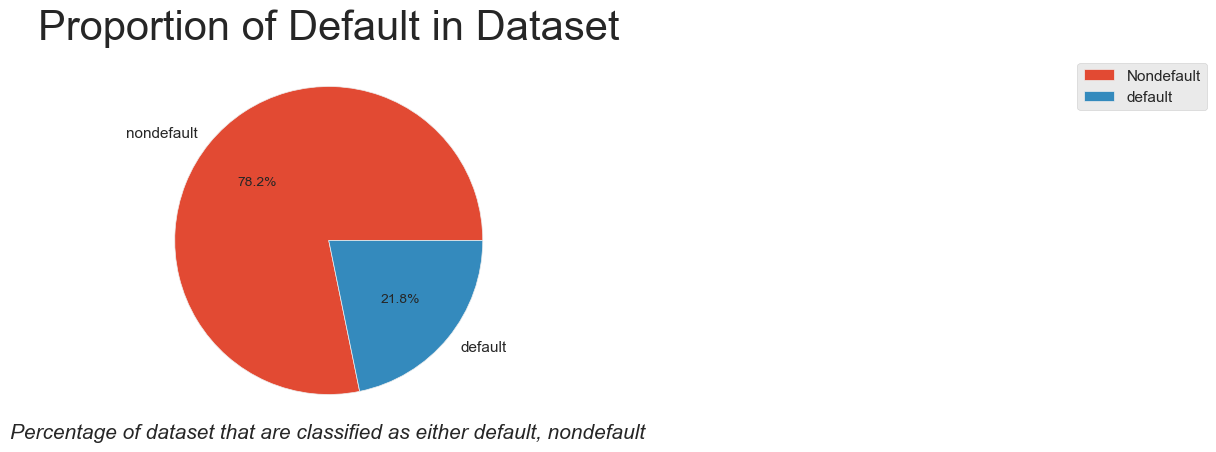

In [427]:
# Plot the proportion of default in dataset
plot1 = plt.figure(figsize=(15,5))
names = ['nondefault','default']
perc =df_train['good_bad_flag'].replace({1: 'default', 0:'nondefault'}).value_counts()
perc.name = ''
perc.plot(kind='pie', labels=names, autopct='%1.1f%%')
plt.title('Proportion of Default in Dataset', fontsize = 30)
plt.figtext(0.30, 0.1, 'Percentage of dataset that are classified as either default, nondefault',
            horizontalalignment ='left', fontsize = 15, style='italic')
plt.legend(df_train['good_bad_flag'].replace({0:'Nondefault', 1:'default'}).value_counts().index,
           bbox_to_anchor=(2.8,0.9), loc="right")

plt.show()

- As shown in the figure above, there is a huge difference in terms of the proportion of the clients that defaulted versus those that did not default on their credit.

Only ~22% (711) cases or clients in the dataset are default while 78.2% (2553) transactions are nondefault with ratio of 3.59 indicating that there is a class imbalance in the dataset. Building a machine learning model on a skewed data as shown here, the nondefault transactions will influence the training of the model almost entirely, thus affecting the results.

In [428]:
df_train.head(2)

,customerid,bank_account_type,bank_name_clients,employment_status_clients,level_of_education_clients,loannumber,loanamount,totaldue,termdays,days_in_advance,due_day,approveddate,good_bad_flag,birth_year,age,age_category
0,8a858e135cb22031015cbafc76964ebd,Savings,GT Bank,Permanent,missing,1,10000.0,11500.0,15.0,1.0,5.0,2017-07-05 14:29:48,0,1973,49,adults
1,8a858e275c7ea5ec015c82482d7c3996,Savings,Sterling Bank,Permanent,missing,1,10000.0,13000.0,30.0,-3.0,7.0,2017-07-10 21:21:46,1,1986,37,adults


## Exploring the data by the object type variables (Univariate Analysis)

In [429]:
print("Object type columns:",np.count_nonzero(df_train.select_dtypes('object').columns))
print(df_train.select_dtypes('object').columns)

Object type columns: 6
Index(['customerid', 'bank_account_type', 'bank_name_clients',
       'employment_status_clients', 'level_of_education_clients',
       'age_category'],
      dtype='object')


There are 6 object type columns in our dataset and their names are specified above. Now, we will try and explore our dataset by these variables just to get a better insights into our dataset.

In [430]:
def plot_percentage(df, x):
    sns.set(style="darkgrid")

    # create the bar chart
    ax = sns.barplot(y=df.index, x="Percentage", orient = 'h', data=df)

    # set the chart title and axis labels
    plt.title("Percentage distribution of " + x)
    plt.ylabel(x)
    plt.xlabel("Percentage")

    # add percentage values on top of each bar
    for i in ax.containers:
        ax.bar_label(i, label_type='edge', fontsize=8, rotation='horizontal')

    # rotate the x-axis labels
    #plt.xticks(rotation='horizontal')

    # show the chart
    plt.show()

In [431]:
def count_percentage(df, column):
    counts = df[column].value_counts()
    percentages = counts / counts.sum() * 100
    _df = pd.concat([counts, percentages], axis=1)
    _df.columns = ['Count', 'Percentage']
    _df = _df.sort_values(by='Percentage', ascending=False)
    _df = _df[_df['Count'] >= 0]
    return _df

In [432]:
bank_type_df = count_percentage(df_train, 'bank_account_type')
bank_name__df = count_percentage(df_train, 'bank_name_clients')
employment_status_df = count_percentage(df_train, 'employment_status_clients') 
education__df = count_percentage(df_train, 'level_of_education_clients')
age_category_df = count_percentage(df_train,'age_category')


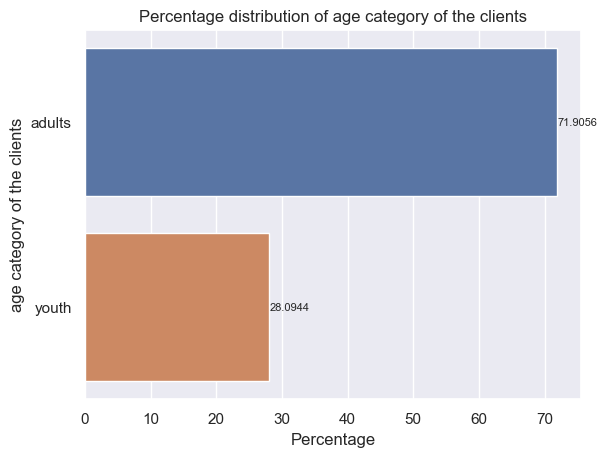

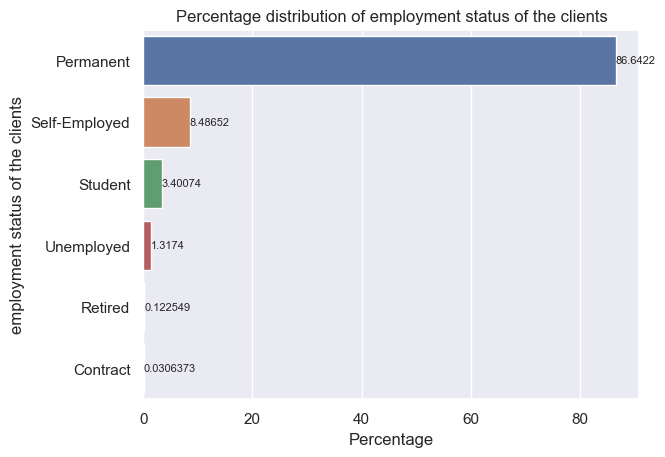

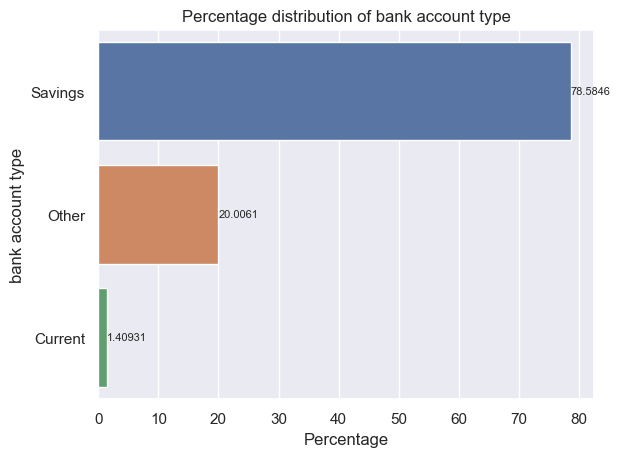

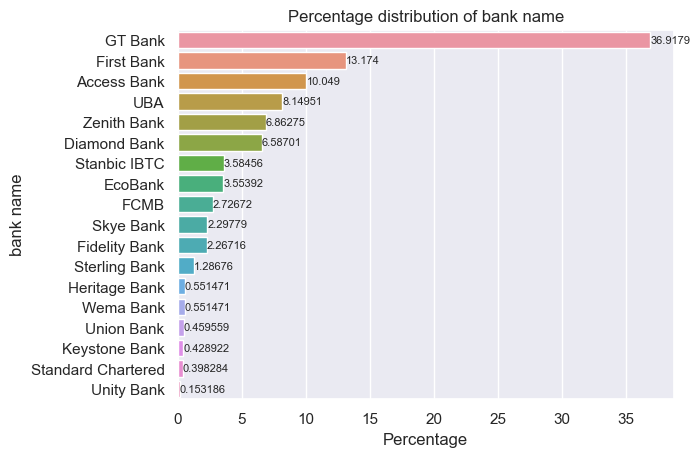

In [433]:
plot_percentage(age_category_df, 'age category of the clients')
plot_percentage(employment_status_df, 'employment status of the clients')
plot_percentage(bank_type_df, 'bank account type')
plot_percentage(bank_name__df, 'bank name')


<a id='feature-correlation'></a>
<font size="+3" color='#780404'><b> Multivariate Analysis</b></font>  

In [434]:

def plot_employment_status(df):
    # Create a bar plot for employment status vs. loan default
    plt.figure(figsize=(8, 6))
    sns.countplot(x='employment_status_clients', hue='good_bad_flag', data=df)
    plt.title('Employment Status vs. Loan Default')
    plt.xlabel('Employment Status')
    plt.ylabel('Count')
    plt.legend(title='Loan Default', loc='upper right', labels=['Good', 'Bad'])
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

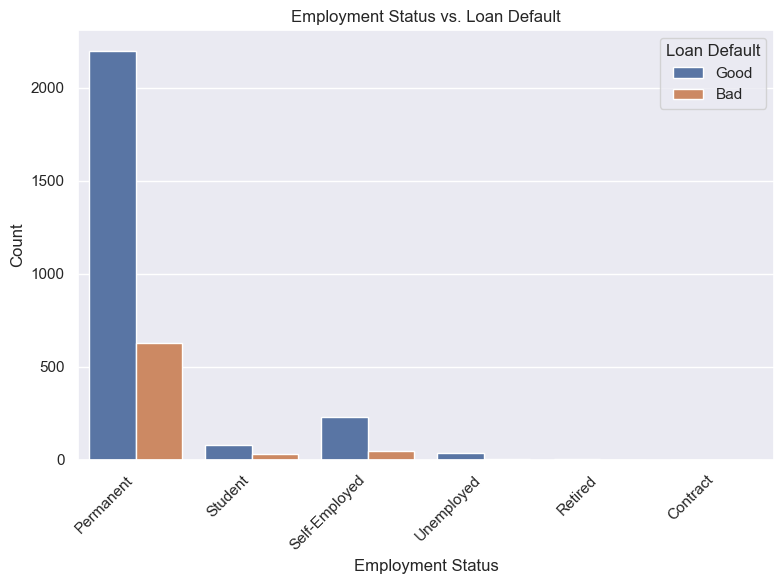

In [435]:
plot_employment_status(df_train)


- Most clients that defaulted/undefaulted were permanent employees, followed by those that were self-employed, students and lastly those that were unemployed.

In [436]:
df_train.head(2)

,customerid,bank_account_type,bank_name_clients,employment_status_clients,level_of_education_clients,loannumber,loanamount,totaldue,termdays,days_in_advance,due_day,approveddate,good_bad_flag,birth_year,age,age_category
0,8a858e135cb22031015cbafc76964ebd,Savings,GT Bank,Permanent,missing,1,10000.0,11500.0,15.0,1.0,5.0,2017-07-05 14:29:48,0,1973,49,adults
1,8a858e275c7ea5ec015c82482d7c3996,Savings,Sterling Bank,Permanent,missing,1,10000.0,13000.0,30.0,-3.0,7.0,2017-07-10 21:21:46,1,1986,37,adults


<a id='feature-correlation'></a>
<font size="+3" color='#780404'><b> Feature Correlation</b></font>  


#### CORRELATION MATRIX

`Correlation Matrix` is an important tool used to quickly evaluate the linear correlation between variables, in this case `loan default prediction` features. As clearly explained here, a positive linear correlation value between two variables means that they move in a similar way; a negative linear correlation value between two variables means that they move in opposite ways. Finally, if the correlation value is close to 0, then their trends are not related.

/var/folders/mc/wtr2th093fscq0l5wyyg1yg00000gq/T/ipykernel_39685/3948725840.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_train.corr()


<Axes: >

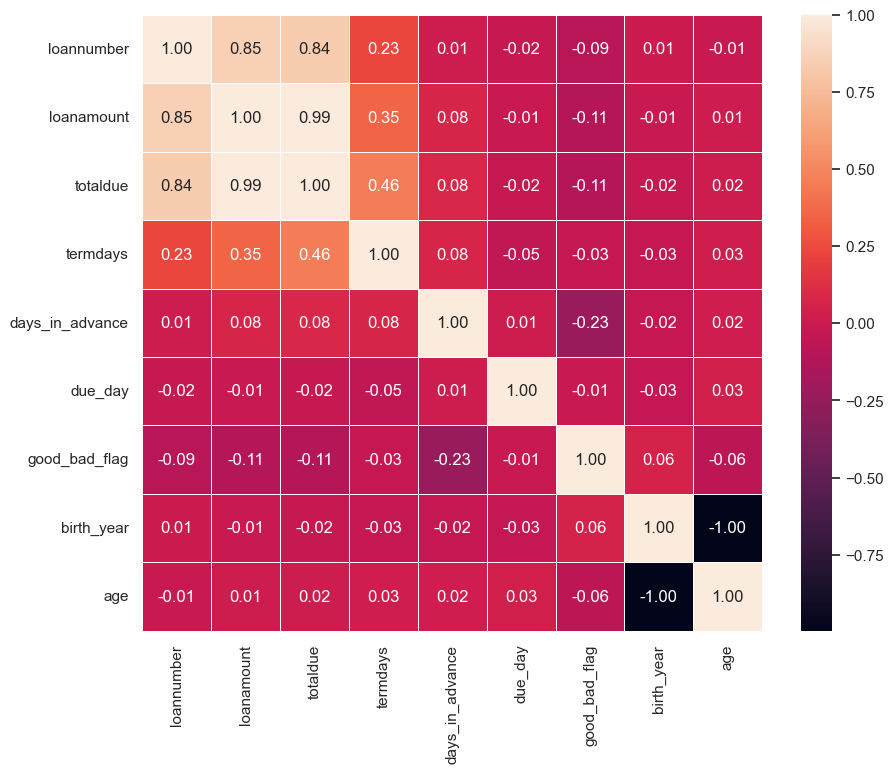

In [437]:
corr_matrix = df_train.corr()

plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidths= 0.5)

- Looking at the figure above , we can see that there is a number of features which seem to show no linear correlation or whatsoever with our target variable (i.e. `good_bad_flag`). However, there are other features that appear to have a correlation with each other. Therefore, let us explore other feature selection methods to determine which features would be useful in building our model.

<a id='feature-selection'></a>
<font size="+3" color='#780404'><b> Feature Selection </b></font>  


### Feature selection using feature correlation technique

In [438]:

df_train.dtypes

customerid                            object
bank_account_type                     object
bank_name_clients                     object
employment_status_clients             object
level_of_education_clients            object
loannumber                             int64
loanamount                           float64
totaldue                             float64
termdays                             float64
days_in_advance                      float64
due_day                              float64
approveddate                  datetime64[ns]
good_bad_flag                          int64
birth_year                             int64
age                                    int64
age_category                          object
dtype: object

In [439]:
#description of the categorical/object type columns
df_train.describe(include='O')

,customerid,bank_account_type,bank_name_clients,employment_status_clients,level_of_education_clients,age_category
count,3264,3264,3264,3264,3264,3264
unique,3264,3,18,6,5,2
top,8a858e135cb22031015cbafc76964ebd,Savings,GT Bank,Permanent,missing,adults
freq,1,2565,1205,2828,2824,2347


In [440]:
noncat = df_train.drop(['bank_account_type', 'bank_name_clients', 'employment_status_clients', 'level_of_education_clients', 'age_category'], axis=1)
# Calculate the correlation between each feature and the target variable
corr = df_train.corr()['good_bad_flag'].abs().sort_values(ascending=False)

# Select all features with non-zero correlation
top_features = corr[corr != 0].index

# Print the top features
f1 = list(top_features)
f1

/var/folders/mc/wtr2th093fscq0l5wyyg1yg00000gq/T/ipykernel_39685/370016899.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_train.corr()['good_bad_flag'].abs().sort_values(ascending=False)


['good_bad_flag',
 'days_in_advance',
 'loanamount',
 'totaldue',
 'loannumber',
 'age',
 'birth_year',
 'termdays',
 'due_day']

### feature importance using Random Forest Classifier Method

In [441]:
X = df_train.drop(['bank_account_type', 'bank_name_clients','approveddate','customerid','employment_status_clients', 'level_of_education_clients', 'age_category'], axis=1)
y = df_train['good_bad_flag']

In [442]:
df_train

,customerid,bank_account_type,bank_name_clients,employment_status_clients,level_of_education_clients,loannumber,loanamount,totaldue,termdays,days_in_advance,due_day,approveddate,good_bad_flag,birth_year,age,age_category
0,8a858e135cb22031015cbafc76964ebd,Savings,GT Bank,Permanent,missing,1,10000.000000,11500.000000,15.0,1.000000,5.000000,2017-07-05 14:29:48,0,1973,49,adults
1,8a858e275c7ea5ec015c82482d7c3996,Savings,Sterling Bank,Permanent,missing,1,10000.000000,13000.000000,30.0,-3.000000,7.000000,2017-07-10 21:21:46,1,1986,37,adults
2,8a858e5b5bd99460015bdc95cd485634,Savings,Fidelity Bank,Permanent,missing,3,10000.000000,12000.000000,20.0,-0.333333,15.000000,2017-07-13 15:40:27,0,1987,36,adults
3,8a858efd5ca70688015cabd1f1e94b55,Savings,GT Bank,Permanent,missing,1,10000.000000,11500.000000,15.0,-18.000000,30.000000,2017-07-26 21:03:17,0,1991,32,youth
4,8a858ea05a859123015a8892914d15b7,Savings,Access Bank,Permanent,missing,5,14000.000000,17600.000000,30.0,3.200000,26.000000,2017-07-23 21:44:43,0,1990,33,youth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267,8a858f735b437619015b437bf3d30bdc,Savings,GT Bank,Permanent,missing,2,10000.000000,11500.000000,15.0,2.000000,26.000000,2017-07-14 22:08:22,1,1982,40,adults
3268,8a858fc45c5f93be015c61e0e5e55e38,Savings,GT Bank,Permanent,missing,2,10000.000000,11500.000000,15.0,3.500000,8.000000,2017-07-17 08:52:06,0,1986,37,adults
3269,8a85897353d85af80153d8a368020159,Other,UBA,Self-Employed,missing,10,15500.000000,17997.500000,22.5,2.400000,11.100000,2017-07-10 18:04:26,0,1983,40,adults
3270,8a858f155554552501555588ca2b3b40,Other,Stanbic IBTC,Permanent,Graduate,6,11666.666667,14583.333333,27.5,0.833333,18.166667,2017-07-22 16:07:16,0,1985,37,adults


In [443]:
X.head(2)

,loannumber,loanamount,totaldue,termdays,days_in_advance,due_day,good_bad_flag,birth_year,age
0,1,10000.0,11500.0,15.0,1.0,5.0,0,1973,49
1,1,10000.0,13000.0,30.0,-3.0,7.0,1,1986,37


In [444]:
y

0       0
1       1
2       0
3       0
4       0
       ..
3267    1
3268    0
3269    0
3270    0
3271    0
Name: good_bad_flag, Length: 3264, dtype: int64

In [445]:
# Train a random forest classifier on the entire dataset
rfc = RandomForestClassifier()
rfc.fit(X, y)

# Get the feature importances from the trained model
importances = rfc.feature_importances_

# Sort the feature importances in descending order
indices = importances.argsort()[::-1]

# Select the top N features based on their importance scores
top_features1 = X.columns[indices][:20]

# Print the top features
f2 = list(top_features1)
f2

['good_bad_flag',
 'days_in_advance',
 'due_day',
 'totaldue',
 'loanamount',
 'age',
 'birth_year',
 'loannumber',
 'termdays']

In [446]:
from sklearn.feature_selection import mutual_info_classif

### feature importance using mutual class info classification

In [447]:
importances = mutual_info_classif(X, y)
feat_importance = pd.Series(importances, X.columns[0:len(X.columns)])
feat_importance_sorted = feat_importance.sort_values(ascending=False)
main_features = feat_importance_sorted[0:10].index
f3 = list(main_features)
f3

['good_bad_flag',
 'days_in_advance',
 'loanamount',
 'due_day',
 'age',
 'birth_year',
 'totaldue',
 'loannumber',
 'termdays']

- From all the above feature importance techniques, we can see that `days_in_advance`, `due_day` and `total_due` are three features which are prevalent in their importance in all three feature importance techniques.

In [448]:
features = f1 + f2 + f3
selected_features = list(set(features))

In [449]:
selected_features

['days_in_advance',
 'totaldue',
 'age',
 'good_bad_flag',
 'loanamount',
 'birth_year',
 'due_day',
 'termdays',
 'loannumber']

<a id='data-transformation'></a>
<font size="+3" color='#780404'><b> Data Transformation</b></font>  
<a id='modeling'></a>

SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. SMOTE (Synthetic Minority Over-sampling Technique) is a popular method used in the field of imbalanced learning to address the issue of class imbalance in datasets. Class imbalance occurs when one class (the minority class) is significantly underrepresented compared to another class (the majority class). This imbalance can lead to biased model performance, as the model may tend to favor the majority class, resulting in poor predictions for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together. SMOTE is specifically designed to tackle imbalanced datasets by generating synthetic samples for the minority class. In our dataset, we saw that there was an imbalanced dataset in our target variable with ~78% of the clients identifying as non-defaulters and only ~ 22% of other clients as defaulters.


In [450]:
X = df_train[selected_features]

In [451]:

X = df_train.drop(['bank_account_type', 'good_bad_flag','bank_name_clients','approveddate','customerid','employment_status_clients', 'level_of_education_clients', 'age_category'], axis=1)
X

,loannumber,loanamount,totaldue,termdays,days_in_advance,due_day,birth_year,age
0,1,10000.000000,11500.000000,15.0,1.000000,5.000000,1973,49
1,1,10000.000000,13000.000000,30.0,-3.000000,7.000000,1986,37
2,3,10000.000000,12000.000000,20.0,-0.333333,15.000000,1987,36
3,1,10000.000000,11500.000000,15.0,-18.000000,30.000000,1991,32
4,5,14000.000000,17600.000000,30.0,3.200000,26.000000,1990,33
...,...,...,...,...,...,...,...,...
3267,2,10000.000000,11500.000000,15.0,2.000000,26.000000,1982,40
3268,2,10000.000000,11500.000000,15.0,3.500000,8.000000,1986,37
3269,10,15500.000000,17997.500000,22.5,2.400000,11.100000,1983,40
3270,6,11666.666667,14583.333333,27.5,0.833333,18.166667,1985,37


In [452]:
X

,loannumber,loanamount,totaldue,termdays,days_in_advance,due_day,birth_year,age
0,1,10000.000000,11500.000000,15.0,1.000000,5.000000,1973,49
1,1,10000.000000,13000.000000,30.0,-3.000000,7.000000,1986,37
2,3,10000.000000,12000.000000,20.0,-0.333333,15.000000,1987,36
3,1,10000.000000,11500.000000,15.0,-18.000000,30.000000,1991,32
4,5,14000.000000,17600.000000,30.0,3.200000,26.000000,1990,33
...,...,...,...,...,...,...,...,...
3267,2,10000.000000,11500.000000,15.0,2.000000,26.000000,1982,40
3268,2,10000.000000,11500.000000,15.0,3.500000,8.000000,1986,37
3269,10,15500.000000,17997.500000,22.5,2.400000,11.100000,1983,40
3270,6,11666.666667,14583.333333,27.5,0.833333,18.166667,1985,37


In [453]:
# Instantiate the SMOTE algorithm
smote = SMOTE(random_state=42)

# Fit the algorithm to the data and resample
X_resampled, y_resampled = smote.fit_resample(X.astype('int64'), y)

In [454]:
!pip install resample

In [455]:
y_resampled.value_counts()

0    2553
1    2553
Name: good_bad_flag, dtype: int64

In [456]:
X_resampled

,loannumber,loanamount,totaldue,termdays,days_in_advance,due_day,birth_year,age
0,1,10000,11500,15,1,5,1973,49
1,1,10000,13000,30,-3,7,1986,37
2,3,10000,12000,20,0,15,1987,36
3,1,10000,11500,15,-18,30,1991,32
4,5,14000,17600,30,3,26,1990,33
...,...,...,...,...,...,...,...,...
5101,2,10000,12250,22,2,18,1987,35
5102,1,10000,11500,15,-4,10,1989,33
5103,1,10000,13000,30,22,22,1983,39
5104,1,10000,11500,15,0,7,1987,34


- Now, there is a class balance in the target variable as shown above.

<a id='data-splitting'></a>
<font size="+3" color='#780404'><b> Data Splitting</b></font>  
<a id='modeling'></a>

In [457]:

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=123)

In [458]:
X_resampled

,loannumber,loanamount,totaldue,termdays,days_in_advance,due_day,birth_year,age
0,1,10000,11500,15,1,5,1973,49
1,1,10000,13000,30,-3,7,1986,37
2,3,10000,12000,20,0,15,1987,36
3,1,10000,11500,15,-18,30,1991,32
4,5,14000,17600,30,3,26,1990,33
...,...,...,...,...,...,...,...,...
5101,2,10000,12250,22,2,18,1987,35
5102,1,10000,11500,15,-4,10,1989,33
5103,1,10000,13000,30,22,22,1983,39
5104,1,10000,11500,15,0,7,1987,34


<a id='Model Selection'></a>
<font size="+3" color='#780404'><b> Model Selection: Classification Models</b></font>  
<a id='modeling'></a>

In [459]:
model_pipeline = []
model_pipeline.append(LinearSVC())
model_pipeline.append(RandomForestClassifier())
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(SVC())
model_pipeline.append(LogisticRegression())
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))

In [460]:
X_train

,loannumber,loanamount,totaldue,termdays,days_in_advance,due_day,birth_year,age
4163,2,10000,13000,30,-1,16,1980,42
1629,1,10000,13000,30,1,27,1989,33
3053,3,10000,13000,30,6,14,1969,54
61,4,10000,13000,30,0,20,1986,37
2897,13,29230,33407,30,6,17,1982,41
...,...,...,...,...,...,...,...,...
1593,6,15000,18383,27,1,18,1986,37
4060,1,10000,11500,15,0,17,1989,33
1346,11,25000,28486,27,3,11,1992,31
3454,9,10000,11500,15,-2,14,1982,39


In [461]:
y_train

4163    1
1629    0
3053    0
61      0
2897    0
       ..
1593    0
4060    1
1346    1
3454    1
3582    1
Name: good_bad_flag, Length: 4595, dtype: int64

In [462]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [463]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

<a id='Model Training'></a>
<font size="+2" color='#780404'><b> model training</b></font>  
<a id='modeling'></a>

In [464]:
model_list = ['LinearSVC', 'RandomForestClassifier', 'DecisionTreeClassifier',
              'SVC', 'LogisticRegression', 'KNeighborsClassifier', 'GradientBoostingClassifier']
f1_list = []
pr_list = []
rc_list = []
acc_list = []
cm_list = []
roc_list = []
i = 0
for model in model_pipeline:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1_list.append(f1_score(y_test, y_pred, average='weighted'))
    pr_list.append(precision_score(y_test, y_pred, average='weighted'))
    rc_list.append(recall_score(y_test, y_pred, average='weighted'))
    acc_list.append(accuracy_score(y_test, y_pred))
    roc_list.append(roc_auc_score(y_test, y_pred))
    cm_list.append(confusion_matrix(y_test, y_pred))
    
    # save the model to disk
    filename = model_list[i]
    pickle.dump(model, open(filename, 'wb'))
    i = i + 1

/Users/da_m1_23/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


<a id='Model Evaluation'></a>
<font size="+2" color='#780404'><b> model evaluation</b></font>  
<a id='model evaluation'></a>

In [465]:
c_result = pd.DataFrame({'Model': model_list, 'F1': f1_list, 'Precision': pr_list, 'Recall': rc_list, 'Accuracy': acc_list, 'ROC-AUC': roc_list})
c_result

,Model,F1,Precision,Recall,Accuracy,ROC-AUC
0,LinearSVC,0.413337,0.665520,0.530333,0.530333,0.532959
1,RandomForestClassifier,0.788457,0.789451,0.788650,0.788650,0.788482
2,DecisionTreeClassifier,0.741138,0.743358,0.741683,0.741683,0.741421
3,SVC,0.555348,0.574588,0.567515,0.567515,0.566546
4,LogisticRegression,0.620326,0.620471,0.620352,0.620352,0.620408
5,KNeighborsClassifier,0.744748,0.748420,0.745597,0.745597,0.745266
6,GradientBoostingClassifier,0.727590,0.729666,0.727984,0.727984,0.728216


/var/folders/mc/wtr2th093fscq0l5wyyg1yg00000gq/T/ipykernel_39685/412488823.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=75, ha='right');


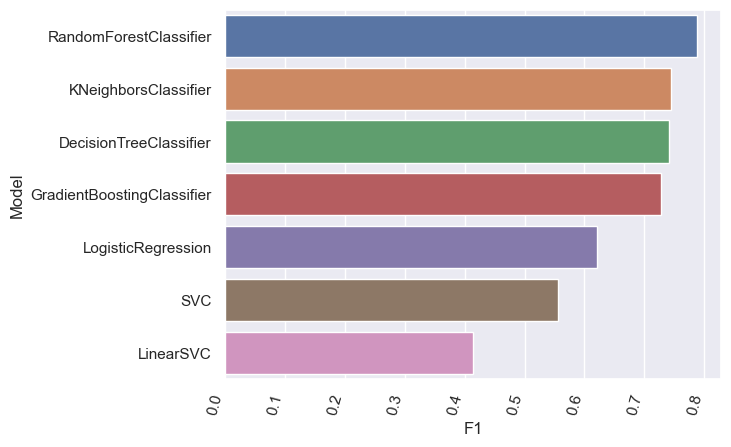

In [466]:
#Lets evaluate the model perfomance based on the "F1-Score" metric
f1_df = c_result[['Model', 'F1']]
f1_df_sorted = f1_df.sort_values(by='F1', ascending=False)
ax = sns.barplot(y = 'Model', x = 'F1', data = f1_df_sorted)
ax.set_xticklabels(ax.get_xticklabels(), rotation=75, ha='right');

- In light of the above, Xgboost (Extreme Gradient Boosting) model appears to perform better than RandomForest and Gradient Boosting, and therefore we would take it as our best model with an F1 score of ~78%

<a id='Model Evaluation'></a>
<font size="+2" color='#780404'><b> model testing (making predictions)</b></font>  
<a id='model evaluation'></a>

In [467]:

first_row = X.copy()

# Method 2: Create a new DataFrame 'first_row' using slicing
first_row = X.iloc[[1]].copy()

# Note: In Method 2, we are extracting the first row (index 0) from the DataFrame 'X'
# and creating a new DataFrame 'first_row' using the `copy()` method to avoid modifying the original data.

# Display the 'first_row' DataFrame
first_row

,loannumber,loanamount,totaldue,termdays,days_in_advance,due_day,birth_year,age
1,1,10000.0,13000.0,30.0,-3.0,7.0,1986,37


In [468]:
df_train[df_train['loannumber']== 1]

,customerid,bank_account_type,bank_name_clients,employment_status_clients,level_of_education_clients,loannumber,loanamount,totaldue,termdays,days_in_advance,due_day,approveddate,good_bad_flag,birth_year,age,age_category
0,8a858e135cb22031015cbafc76964ebd,Savings,GT Bank,Permanent,missing,1,10000.0,11500.0,15.0,1.0,5.0,2017-07-05 14:29:48,0,1973,49,adults
1,8a858e275c7ea5ec015c82482d7c3996,Savings,Sterling Bank,Permanent,missing,1,10000.0,13000.0,30.0,-3.0,7.0,2017-07-10 21:21:46,1,1986,37,adults
3,8a858efd5ca70688015cabd1f1e94b55,Savings,GT Bank,Permanent,missing,1,10000.0,11500.0,15.0,-18.0,30.0,2017-07-26 21:03:17,0,1991,32,youth
5,8a858f405d13c45f015d13dd93ec0c1c,Savings,EcoBank,Permanent,missing,1,10000.0,13000.0,30.0,14.0,4.0,2017-07-28 10:13:02,0,1992,30,youth
6,8a858f2a5ce989dd015ce9fc24b1474b,Savings,FCMB,Permanent,missing,1,10000.0,11500.0,15.0,6.0,12.0,2017-07-06 18:25:57,1,1994,28,youth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257,8a8589a453bc422d0153c7d857e0190f,Other,GT Bank,Permanent,missing,1,10000.0,13000.0,30.0,2.0,15.0,2017-07-24 15:02:09,0,1976,47,adults
3260,8a858e045cd5b1d6015ce47a16742d68,Savings,First Bank,Permanent,missing,1,10000.0,11500.0,15.0,0.0,14.0,2017-07-26 12:28:27,0,1987,35,adults
3263,8a858e6f5cd5e874015ce8ea0b996796,Savings,Access Bank,Permanent,missing,1,10000.0,11500.0,15.0,2.0,20.0,2017-07-19 12:28:59,0,1966,57,adults
3266,8a858fbc5cc666c8015cc9b715f420a8,Savings,Stanbic IBTC,Permanent,missing,1,10000.0,11500.0,15.0,4.0,7.0,2017-07-08 08:39:38,0,1967,56,adults


In [469]:
rf.fit(X_train,y_train)
y_pred = rf.predict(first_row)
y_pred

array([1])

<a id='Model Selection'></a>
<font size="+3" color='#780404'><b> Hyperparameter Tuning</b></font>  
<a id='modeling'></a>

Hyperparameter tuning is the process of selecting the best hyperparameters for a machine learning model to optimize its performance on a given task. Hyperparameters are configuration settings that are not learned from the data during the training process, and they control the behavior of the learning algorithm. Examples of hyperparameters include the learning rate, number of trees in a random forest, number of layers in a neural network, etc.

Hyperparameter tuning is essential because choosing the right hyperparameters can significantly impact the model's performance. If the hyperparameters are not set properly, the model may overfit or underfit the data, leading to poor generalization and suboptimal results.

In the context of our model, we can perform hyperparameter tuning for the Random Forest model to find the best set of hyperparameters that maximize the F1-score or any other performance metric of our. Here's how we will do our hyperparameter tuning:

In [470]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Assuming you have already split your data into training and test sets (X_train, X_test, y_train, y_test)

# Create a Random Forest classifier
rf_model = RandomForestClassifier(max_depth=30, n_estimators=320,min_samples_split=2)

# Define the hyperparameters and their respective candidate values for tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define the scoring metric you want to use for evaluation (F1 score in this case)
scorer = make_scorer(f1_score)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring=scorer, cv=4)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Fit the Random Forest model with the best hyperparameters
best_rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train, y_train)

# Make predictions on the test set using the tuned model
y_pred = rf_model.predict(X_test)

# Evaluate the model's performance using the F1 score
f1 = f1_score(y_test, y_pred)
print("Best Hyperparameters:", best_params)
print("Test F1 Score:", f1)


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Test F1 Score: 0.822857142857143


In [471]:
import pickle
import joblib

In [472]:
#Save the random_forest model to a file
filename = 'random_forest_model.sav'
joblib.dump(rf_model, filename)

#saving the decision tree model

filename = 'decision_tree_model.sav'
joblib.dump(dt, filename)

print("Both models saved successfully.")

Both models saved successfully.
